# Predicting Movie Success

*Aurthor: Avijeet Kartikay*

Movies are loved all over the world, however, there is no particular way that we could predict a movie outcome. Here we have come up with an engineered approach where we can predict whether a movie would be successful based on the features like genre, cast, production company using data provided in the movie data set from Kaggle.

In [1]:
#Import packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Old Approach
credits = pd.read_csv('dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('dataset/tmdb_5000_movies.csv')

#Filters to limit the data and remove outliers
movies = movies[movies.original_language == 'en']
movies = movies[movies.vote_count != 0]
movies = movies[movies.genres != '[]']
movies['release_year'] = movies['release_date'].str.split('-').str[0].astype(int)

In [3]:
#Clean the Dataset
#Create new dataframes from Dictionary like columns
def mapper(df, col, new_col):
    temp = []
    for n, row in df.iterrows():
        if row[col] != '[]':
            names = row[col]
        [temp.append(tuple(i.values())+(row[new_col],)) for i in json.loads(row[col])]
    new_df = pd.DataFrame(temp)
    new_df.columns = list(json.loads(names)[0].keys()) + ['movie_id']

    return new_df

In [4]:
credit_cast = mapper(credits, 'cast', 'movie_id')
credit_crew = mapper(credits, 'crew', 'movie_id')
movie_genres = mapper(movies, 'genres', 'id')
movie_keywords = mapper(movies, 'keywords', 'id')
movie_production_companies = mapper(movies, 'production_companies', 'id')
movie_spoken_languages = mapper(movies, 'spoken_languages', 'id')
movie_production_countries = mapper(movies, 'production_countries', 'id')

In [5]:
credit_cast.columns = ['cast_id', 'character', 'credit_id', 'gender', 'actor_id', 'actor_name', 'order','movie_id']
credit_crew.columns = ['credit_id', 'department', 'gender', 'job_id', 'job', 'crew_member', 'movie_id']
movie_genres.columns = ['genre_id','genre','movie_id']
movie_production_companies.columns = ['studio', 'studio_id', 'movie_id']
movie_spoken_languages.columns = ['iso_639_1', 'language', 'movie_id']
movie_production_countries.columns = ['iso_3166_1', 'country', 'movie_id']

In [6]:
movie_test = movies[movies['release_year'] > 2010]
movie_train = movies[movies['release_year'] <= 2010]

In [7]:
#group genre
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
metrics = movie_train[['id','popularity','revenue','runtime','vote_count','vote_average']]
metrics.columns = ['movie_id','popularity','revenue','runtime','vote_count','vote_average']
weights = pd.merge(movie_genres, metrics, on='movie_id',how='inner')
weights = weights.groupby('genre').agg({'movie_id':'count', 'popularity':'mean', 'revenue':'mean','runtime':'mean', 
                           'vote_count':'count','vote_average':'mean'})
#scale the dataset
weights = np.sum(ss.fit_transform(weights),axis=1)

In [8]:
#calculate score based on 
def score_calculator(df1, df2, col):
    joined_df = pd.merge(df1, df2, on ='movie_id')
    temp = joined_df.pivot_table(index = col, columns = 'genre', values = 'genre_id', aggfunc = 'count').fillna(0)
    df_index = temp.index
    score_df = pd.DataFrame(np.matmul(temp.values, weights))
    score_df.index = df_index
    score_df.columns = ['score']
    score_df = score_df.sort_values(by='score',ascending=False).reset_index()
    
    score = pd.merge(df1, score_df, on = col, how = 'inner').groupby('movie_id')['score'].sum().reset_index()
    score.columns = ['movie_id',col+'_score']
    return score

In [9]:
cast_score = score_calculator(credit_cast, movie_genres, 'actor_name')
production_score = score_calculator(movie_production_companies, movie_genres, 'studio')
crew_score = score_calculator(credit_crew, movie_genres, 'crew_member')

In [10]:
movies['release_month'] = movies['release_date'].str.split('-').str[1].astype(int)
def season(row):
    if row >= 1 and row < 3:
        return 'winter'
    elif row >=3  and row < 6:
        return 'spring'
    elif row >= 6 and row < 10:
        return 'summer'
    elif row >= 10 and row < 11:
        return 'autumn'
    else:
        return 'winter'

movies['season'] = movies.release_month.apply(season)
data = movies.drop(['genres', 'homepage', 'keywords', 'original_title', 'overview', 'production_companies', 
                    'release_date', 'production_countries', 'spoken_languages', 'status', 'tagline',
                    'release_month'],axis=1)
data.columns = ['budget', 'movie_id', 'original_language', 'popularity', 'revenue', 'runtime', 'title', 
                'vote_average','vote_count', 'release_year', 'season']
data = pd.merge(data, cast_score, on='movie_id', how='inner')
data = pd.merge(data, production_score, on='movie_id', how='inner')
data = pd.merge(data, crew_score, on='movie_id', how='inner')
data.head()

,budget,movie_id,original_language,popularity,revenue,runtime,title,vote_average,vote_count,release_year,season,actor_name_score,studio_score,crew_member_score
0,237000000,19995,en,150.437577,2787965087,162.0,Avatar,7.2,11800,2009,winter,1579.164753,1675.381361,6633.545818
1,300000000,285,en,139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,2007,spring,2026.448054,726.144274,3253.211259
2,245000000,206647,en,107.376788,880674609,148.0,Spectre,6.3,4466,2015,autumn,1547.013755,1102.121751,6859.013397
3,250000000,49026,en,112.312950,1084939099,165.0,The Dark Knight Rises,7.6,9106,2012,summer,5188.166899,2155.532879,10077.125770
4,260000000,49529,en,43.926995,284139100,132.0,John Carter,6.1,2124,2012,spring,1336.034036,574.998727,5118.766659


In [11]:
#Creating the Target Variables
def create_labels(row):
    if (row['vote_average']>= 6.1)&(row['popularity']>30)&((row['revenue']-row['budget'])>0):
        return 1
    else:
        return 0

data['target'] = data[['vote_average','popularity','revenue', 'budget']].apply(create_labels,axis=1)
data.head()

,budget,movie_id,original_language,popularity,revenue,runtime,title,vote_average,vote_count,release_year,season,actor_name_score,studio_score,crew_member_score,target
0,237000000,19995,en,150.437577,2787965087,162.0,Avatar,7.2,11800,2009,winter,1579.164753,1675.381361,6633.545818,1
1,300000000,285,en,139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,2007,spring,2026.448054,726.144274,3253.211259,1
2,245000000,206647,en,107.376788,880674609,148.0,Spectre,6.3,4466,2015,autumn,1547.013755,1102.121751,6859.013397,1
3,250000000,49026,en,112.312950,1084939099,165.0,The Dark Knight Rises,7.6,9106,2012,summer,5188.166899,2155.532879,10077.125770,1
4,260000000,49529,en,43.926995,284139100,132.0,John Carter,6.1,2124,2012,spring,1336.034036,574.998727,5118.766659,1


In [12]:
#Getting the featrue and target vector
X = pd.get_dummies(data.drop(['movie_id','title','original_language', 
                              'budget', 'revenue', 'vote_average', 'vote_count', 'popularity'],axis=1))
y_train = data[data['release_year']<=2010]['target'].values
y_test = data[data['release_year']>2010]['target'].values

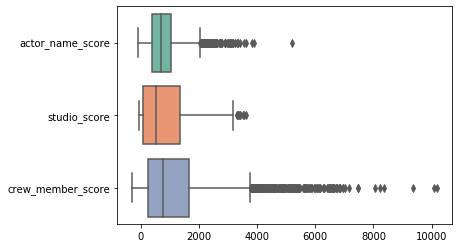

In [13]:
# Some EDA
import seaborn as sns
ax = sns.boxplot(data=data[['actor_name_score', 'studio_score','crew_member_score']], 
                 orient="h", 
                 palette="Set2")

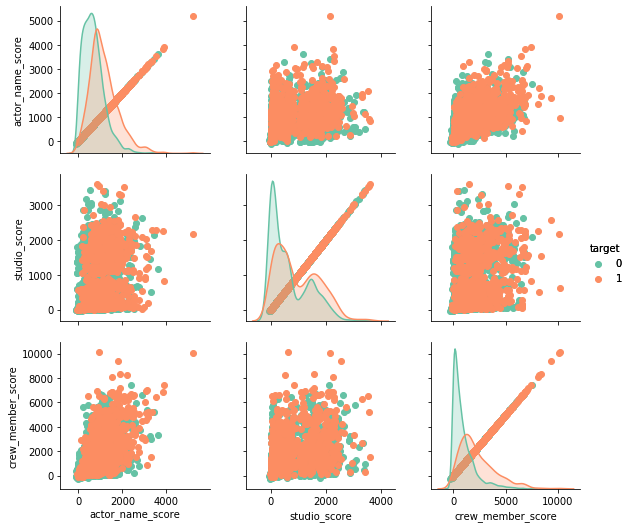

In [14]:
g = sns.pairplot(data, 
                 vars=['actor_name_score', 'studio_score','crew_member_score'], 
                 diag_kind="kde", 
                 palette="Set2",
                 hue='target')
g.map(plt.scatter)
g.add_legend()
plt.show()

In [15]:
X_train = X[X['release_year']<=2010].drop(['target','release_year'],axis=1).values
X_test = X[X['release_year']>2010].drop(['target','release_year'],axis=1).values

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


clfs = {'lr': LogisticRegression(random_state=0),
        'dt': DecisionTreeClassifier(random_state=0),
        'rf': RandomForestClassifier(random_state=0)}

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

In [18]:
param_grids = {}

C_range = [10 ** i for i in range(-4, 5)]
param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': C_range},
              {'clf__multi_class': ['multinomial'],
               'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'clf__C': C_range}]

param_grids['lr'] = param_grid

param_grid = [{'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['dt'] = param_grid

param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['rf'] = param_grid


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipe_clfs[name], param_grid=param_grids[name], scoring='accuracy', cv=StratifiedKFold(
    n_splits=10, shuffle=True, random_state=10))
    
    # Fit the pipeline
    gs.fit(X_train, y_train)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

In [20]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.8518636508442179, {'clf__min_samples_leaf': 30, 'clf__min_samples_split': 2, 'clf__n_estimators': 10}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]

[0.8489964956992673, {'clf__C': 0.01, 'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg'}, <class 'sklearn.linear_model.logistic.LogisticRegression'>]

[0.843262185409366, {'clf__min_samples_leaf': 30, 'clf__min_samples_split': 2}, <class 'sklearn.tree.tree.DecisionTreeClassifier'>]



In [21]:
print(best_score_param_estimators[0][0])

0.8518636508442179


In [22]:
from sklearn.metrics import confusion_matrix
y_pred = best_score_param_estimators[0][2].predict(X_test)
confusion_matrix(y_test, y_pred)

array([[714,  13],
       [244,  48]])

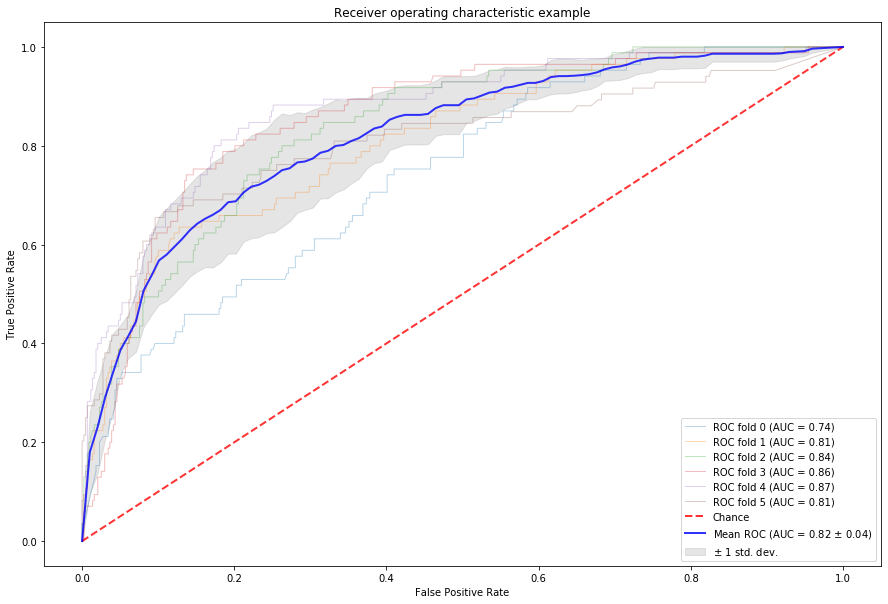

In [23]:
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=6)
classifier = best_score_param_estimators[0][2]

i = 0
tprs = []
aucs = []
plt.figure(figsize=(15,10))
mean_fpr = np.linspace(0, 1, 100)
for train, test in cv.split(X_train, y_train):
    probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
X.to_csv('dataset/movie_dataset_with_scores.csv',index=False)